# Exercises Week 10-11: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2025-2026


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import gammaln
import pandas as pd

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell before you submit.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. We will consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } k\,n \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

*Hint*: In all of the exercises below, use rates that are plausible biologically, especially for $s$ and $k$ (see course). Note that the units here are in minutes.

#### Question 1
1. Modify/complete the code template provided for the Gillespie algorithm to simulate the Telegraph model.

2. Two genes differ by the percentage of time the promoter is ON (gene1: 100%, gene2 : 10%), but the other parameters are the same ($s$, $k$). Let’s modify gene2 so that it expresses at the same level than gene 1, by either increasing its synthesis rate, or decreasing its degradation rate. Let’s say that you also aim to minimize the variance, which scenario is better? For each of the 4 cases (gene1, gene2, gene2 with synthesis rate up, gene2 with degradation rate down), answer with a simulation and show the distribution of the number of molecules and explain your findings.  
*Note*: For each case, report the variance, the mean level of expression, the expected number of molecules, the coefficient of variation of the number of mRNA copies ($CV=\frac{\sigma}{\mu}$) and the probability of the promoter to be in the $ON$ state.  

### Answers 

When the promoter is active, the reactions that the stoichiometry matrix represents are transcription rate (s), degradation rate (k*n) and the switching of the promoter to the inactive state (Koff), hence we have a column for each reaction and a row for each species (n,g) the reactions are happening to. When the promoter is inactive, transcription is not possible, so there are only two columns for the reactions of degradation and switching of the promoter to active state (Kon).

#### Gillespie template

In [2]:
def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telegraph process using the Gillespie algorithm.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        # Notes 4 me: A matrix where rows represent chemical species  and columns represent reactions
        if g == 1: # Promoter is active 
            S = [ [1, -1, 0],
                  [0, 0, -1] 
                ]
            rates = [s, k*n, k_off]
        else: # Promoter is inactive
            S = [ [ -1, 0],
                  [ 0,  1] 
                ]
            rates = [k*n, k_on]

        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        n += S[0][chosen_react]
        g += S[1][chosen_react]

    return n_print, g_print, t_print

In [3]:
def plot_gillespie_telegraph(n, g, t):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=np.min(g), ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(np.min(g), np.max(g)+0.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Common x-label
    plt.xlabel('time [min]')
    
    plt.show()

#### Statistical analysis 


Function to compute the statitical informations asked by question 1.2

In [51]:
def statistics_mrna(n_array, g_array):
    """
    Computes statistics for mRNA numbers from simulation arrays.
    
    Parameters:
    - n_array: array of mRNA counts over time
    - g_array: array of promoter states over time (0 or 1)
    
    Returns:
    - pandas DataFrame with formulas applied
    """
    mean_mrna = np.mean(n_array)  
    variance = np.var(n_array)    
    std_dev = np.sqrt(variance)   
    cv = std_dev / mean_mrna      
    p_on = np.mean(g_array)       
    
    # Build DataFrame
    data = {
        "Quantity": [
            "Mean expression level (μ = mean(n))",
            "Variance (σ² = var(n))",
            "Standard deviation (σ = sqrt(Var(n)))",
            "Coefficient of Variation (CV = σ/μ)",
            "Promoter ON probability (p_on = mean(g))",
            "Expected number of molecules (μ)"
        ],
        "Value": [
            mean_mrna,
            variance,
            std_dev,
            cv,
            p_on,
            mean_mrna
        ]
    }
    
    df = pd.DataFrame(data)
    return df

#### Gene 1

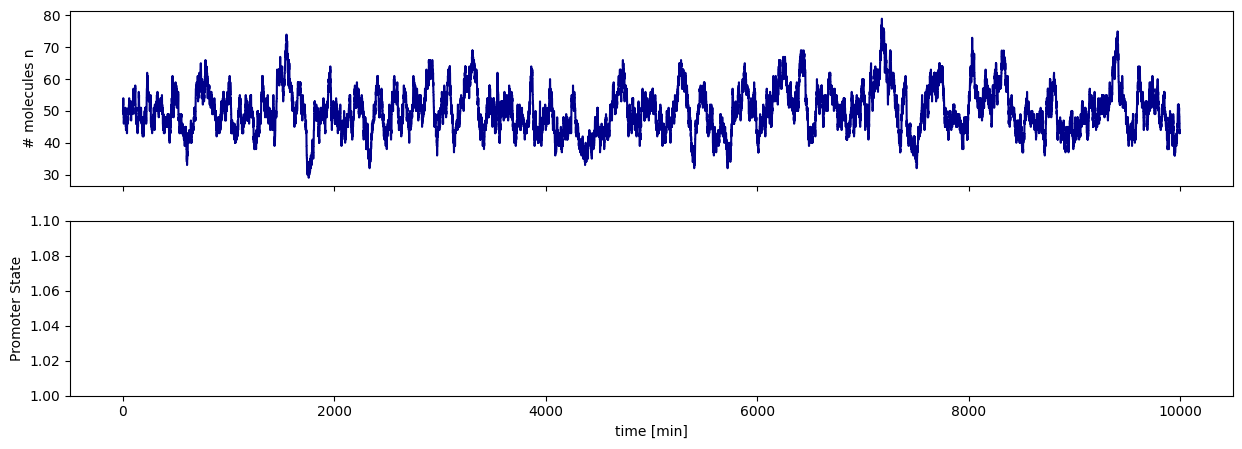

,Quantity,Value
0,Mean expression level (μ = mean(n)),50.131519
1,Variance (σ² = var(n)),49.104151
2,Standard deviation (σ = sqrt(Var(n))),7.007435
3,Coefficient of Variation (CV = σ/μ),0.139781
4,Promoter ON probability (p_on = mean(g)),1.000000
5,Expected number of molecules (μ),50.131519


In [52]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate, 1/k = 50 min
k_off = 0 #Switching off rate, t_on = 1/k_off
k_on  = 1#/120 #Switching on rate, t_off = 1/k_on

p_on = 1

n_0 = s/k * p_on

t_end=10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n1, g1, t1 = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(n1, g1, t1)
statistics_mrna(n1, g1)

This is the distribution of mRNA molecules when the promoter is constitutively active, we observe some fluctuation around the mean (~50) due to the inherent stochasticity of transcription and degradation, with a standard deviation of ~6.4, giving a coefficient of variation of ~0.125.

#### Gene 2 <a id="gene-2"></a>

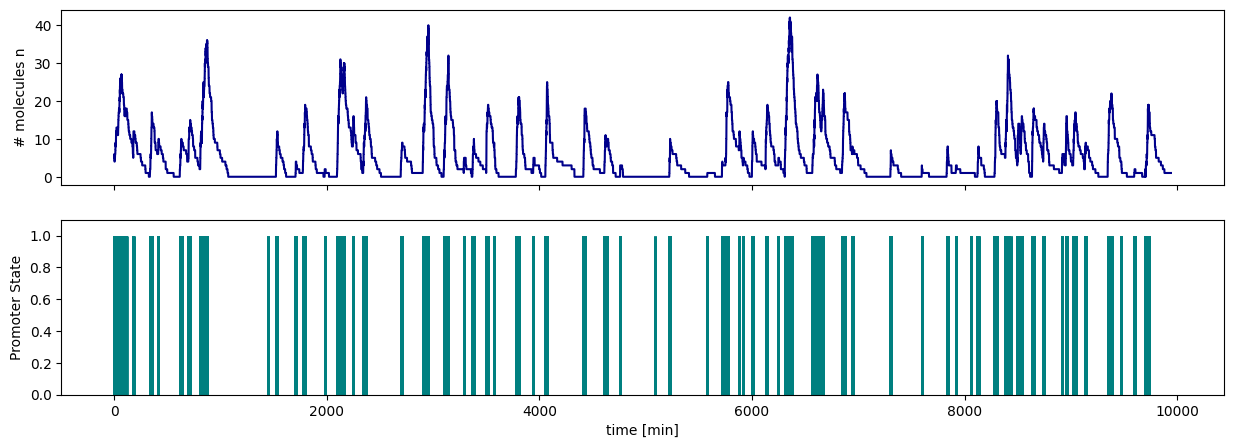

,Quantity,Value
0,Mean expression level (μ = mean(n)),5.321947
1,Variance (σ² = var(n)),47.238816
2,Standard deviation (σ = sqrt(Var(n))),6.873050
3,Coefficient of Variation (CV = σ/μ),1.291454
4,Promoter ON probability (p_on = mean(g)),0.111165
5,Expected number of molecules (μ),5.321947


In [28]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate
k_off = 1/15 #Switching off rate, unit min^-1, t_on = 1/k_off 
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n2, g2, t2 = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(n2, g2, t2)
statistics_mrna(n2, g2)


For gene2, with the promoter ON only 10% of the time, the mean expression level is much lower than gene1, in fact around 10% of it. The distribution shows a higher relative noise (noise defined as the variability of gene expression over time) due to transcription occurring in bursts when the promoter is ON. This translates into a larger varieance and thus a higher coeffeicient of variation despite the fact that s and k are the same as before. This shows that lower promoter activity can result in the increase stochastic variability in gene expression.

#### Gene 2 Increased synthesis rate

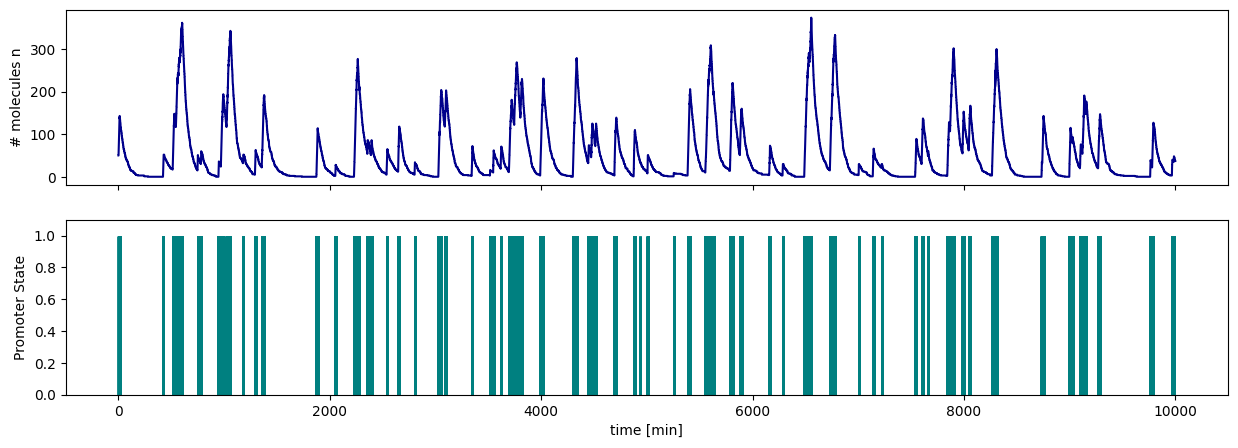

,Quantity,Value
0,Mean expression level (μ = mean(n)),51.280047
1,Variance (σ² = var(n)),4606.501959
2,Standard deviation (σ = sqrt(Var(n))),67.871216
3,Coefficient of Variation (CV = σ/μ),1.323540
4,Promoter ON probability (p_on = mean(g)),0.103716
5,Expected number of molecules (μ),51.280047


In [29]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 10 # Number of initiations per minute
k = 0.02 # Degradation rate
k_off = 1/15 #Switching off rate, unit min^-1, t_on = 1/k_off
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

ns2, gs2, ts2 = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(ns2, gs2, ts2)
statistics_mrna(ns2, gs2)

Since we want to achieve a similar expression rate compared to when the promoter is constitutively on, we analytically compare mean expressions.

Since $\mu = \frac{s}{k} \cdot p_{ON}$, by using the condition that we want the mean expression to be equal, we can do: 

$\frac{s}{k} \cdot p1_{ON}= \frac{s'}{k'} \cdot p2_{ON}$,

and solve for $s' = s \cdot \frac{p_{ON,1}}{p_{ON,2}} = 1 \cdot \frac{1}{0.1} = 10$.

With this value for synthesis rate we indeed find that the mean expression is similar, however, the variance skyrockets as the low promoter occupancy leads to infrequent but large transcriptional bursts, increasing noise relative to the mean.

#### Gene 2 Reduced degradation rate

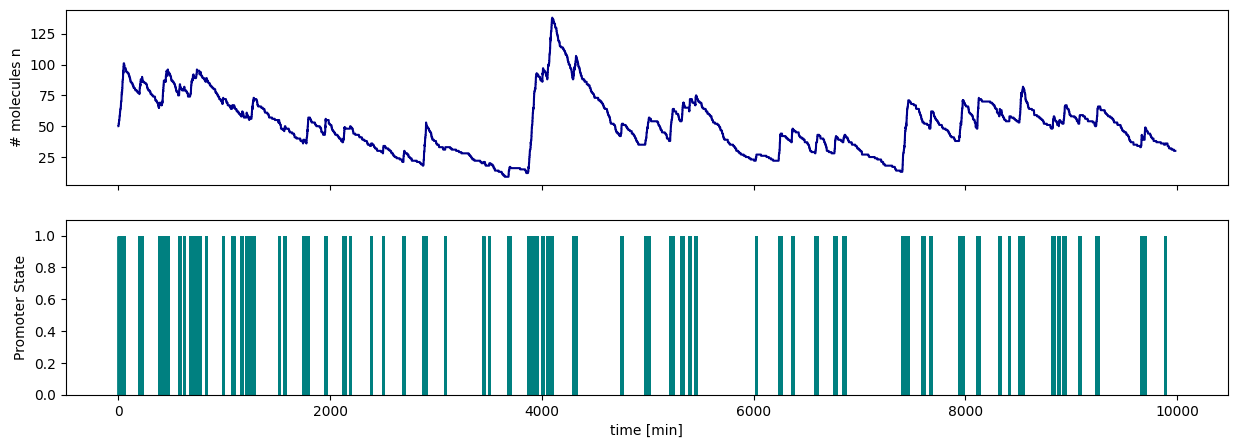

,Quantity,Value
0,Mean expression level (μ = mean(n)),50.673685
1,Variance (σ² = var(n)),509.796133
2,Standard deviation (σ = sqrt(Var(n))),22.578665
3,Coefficient of Variation (CV = σ/μ),0.445570
4,Promoter ON probability (p_on = mean(g)),0.097926
5,Expected number of molecules (μ),50.673685


In [30]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.002 # Degradation rate
k_off = 1/15 #Switching off rate unit min^-1, t_on = 1/k_off
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

nd2, gd2, td2 = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(nd2, gd2, td2)
statistics_mrna(nd2, gd2)

With a similar calculation as before, we can calculate the degradation rate to be:

$k' = k \cdot \frac{p_{ON,2}}{p_{ON,1}} = 0.02 \cdot \frac{0.1}{1} = 0.002$

Again, like this we obtain a mean expression rate of 50. However, the variance is significantly lower when compared to increasing the sysnthesis rate strategy. This is because mRNA molecules persist longer, which averages out the bursts from infrequent promoter activation, leading to lower variance and reduced noise. Therefore, to minimize variance it is better to decrease degradation rate. 

In [ ]:
#Questions for assitants: check calculation and are not mean expression levels and expected number of molecules the same thing??

#### Question 2
1. Identify parameters that results in a Poisson distribution of mRNA numbers. Explain why these parameters produce a Poisson distribution. Show the empiral histogram and overlay an exact Poisson distribution. In this regime, explain how the parameters of the Telegraph model relate to the parameter of the Poisson distribution. *Hint*: $k_{off}=0$ with $g(t=0)=1$ is not the right answer. 

2. Find parameters where the mRNA distribution deviates from the Poisson. *Hint*: Look for a regime that yields a bimodal distribution. Explain your reasoning.

#### Answer 2.1

To obtain a Poisson distribution, we want parameters that revert the system back to a simple birth-death process ($dn/dt = s - kn$) with a constant synthesis rate and a degradation rate proportional to the mRNA count. To do so, we set the synthesis and degradation rates to biologically plausible values (same as given above) and make it so there is virtually no promoter switching (the promoter is always on). Therefore, we set a k$_{on}$ that is significantly larger than the k$_{off}$. All together, this leads to Poisson distributed (mean ${\lambda} = s/k$) mRNA counts in the steady state as shown in the histogram below.

####  Helper functions for the Poisson distribution

In [3]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

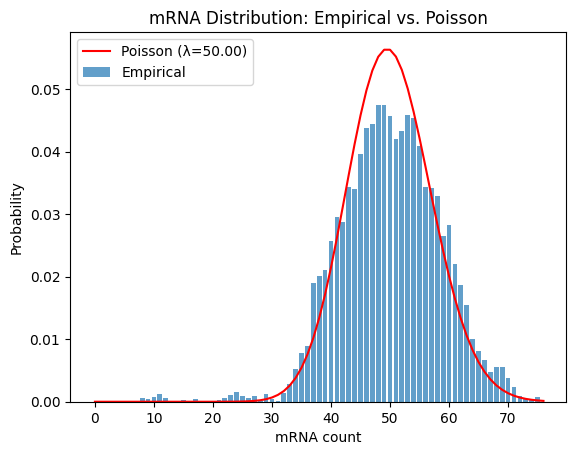

In [59]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state

#Find Parameters giving Poisson distribution
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate,  unit min^-1
k_off = 0.001 #Switching off rate, unit min^-1, t_on = 1/k_off
k_on  = 1000 #Switching on rate, unit min^-1, t_off = 1/k_on

n_0=0

DT = 0.01 # min


t_end = 100 * 1/k # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Empirical histogram of mRNA counts
counts, bins = np.histogram(n, bins=range(max(n)+1), density=True)
# density=True normalizes the histogram so that the sum of the bin heights is 1 (probability density function) so that it can be directly compared to the theoretical Poisson distribution.

# Poisson distribution
lam = s / k
poisson_probs = Poisson(lam, np.arange(max(n)+1))

# Plotting
plt.bar(bins[:-1], counts, width=0.8, label="Empirical", alpha=0.7)
plt.plot(np.arange(max(n)+1), poisson_probs, 'r-', label=f"Poisson (λ={lam:.2f})")
plt.xlabel("mRNA count")
plt.ylabel("Probability")
plt.legend()
plt.title("mRNA Distribution: Empirical vs. Poisson")
plt.show()


#### Answer 2.2

In order to deviate from the Poisson distribution, we aim to create a bimodal distribution. To do so, we leave plausible values for s and k and we set k$_{on}$ and k$_{off}$ to low and equal values. This is to ensure that the promoter stays in a single state for extended period of times, as switching rates are low. They are made equal so that both states occur equally frequently. This allows the promoter's state to have a lasting effect on mRNA production and create a peak at low mRNA counts and another peak in the high mRNA counts.

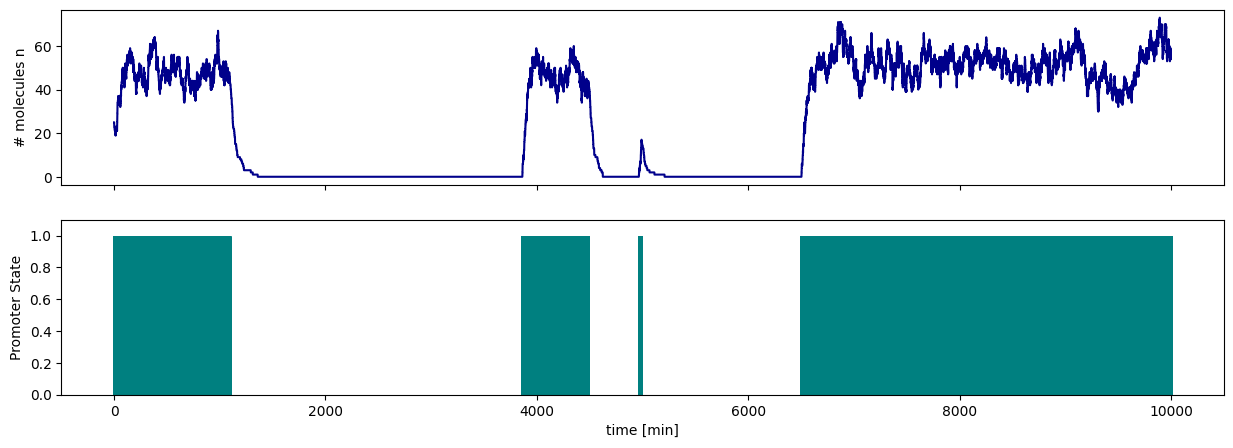

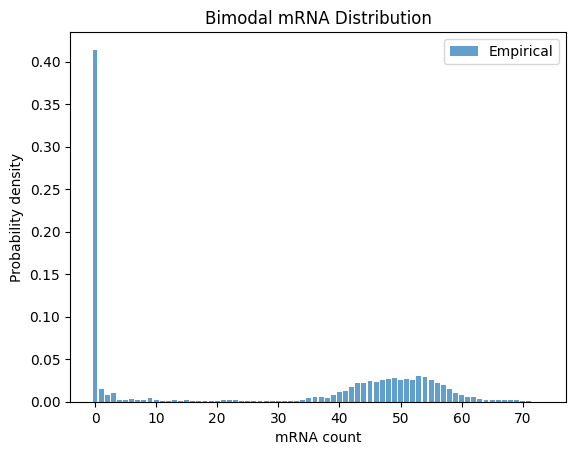

In [10]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate
k_off = 0.001 #Switching off rate, unit min^-1, t_on = 1/k_off
k_on  = 0.001 # Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n2, g2, t2 = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(n2, g2, t2)

int_list = [int(x) for x in n2]

# Plot the empirical histogram
counts, bins = np.histogram(n2, bins=range(max(int_list) + 2), density=True)
plt.bar(bins[:-1], counts, width=0.8, label="Empirical", alpha=0.7)
plt.xlabel("mRNA count")
plt.ylabel("Probability density")
plt.title("Bimodal mRNA Distribution")
plt.legend()
plt.show()

#### Question 3 (Promoter cycle)
Transcription in mammals often requires a more complicated telegraph model (promoter cycle), where the promoter state goes through an $ON$ state, and then sequentially goes through several $OFF_n$ state before returning to the ON state. For example with two $OFF$ states, it would look like: $ON\,(g=1)\longrightarrow OFF_1 (g=2) \longrightarrow OFF_2 (g=3) \longrightarrow ON (g=1)$. This is related to the fact that transcription events often show a refractory period, *i.e.* promoter tend to say off for some amount of time before turning back on. 

1. Modify the above code to implement the promoter cycle with two $OFF$ state. First, use rates as in the example above with the following modifications: $s = 20$, $k = 0.02$, $k_{on-off_1} = 1/15$, $k_{off_1-off_2} = 1/60$ and $k_{off_2-on}  = 1/60$. Show some representative simulations. Plot both the mRNA and promoter state and comment.

2.  Study the distribution of the durations of each $OFF$ interval separately and study the distribution of the total duration of the two $OFF$ intervals. Focus on the shape of the distributions. Explain your findings.

3. (Bonus). Can you explain mathematically and biologically the shape of the distribution ? What would happen if you include more $OFF_n$ states?

In [ ]:
#Adapt the Gillepsie algorithm to the promoter cycle case